In [208]:
import numpy as np
import sys
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from group_lasso import GroupLasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import copy
import warnings
import time
from scipy import stats
%matplotlib inline 

In [9]:
def make_block_matrix(num_groups, group_size, within_gr_corr, between_gr_corr=0, random=False):

    if between_gr_corr != 0:
        if random is True:
            blocks = np.array([np.random.uniform(0, 1, [group_size, group_size])]*(num_groups**2))
        else:
            blocks = np.array([np.ones([group_size, group_size])*between_gr_corr]*(num_groups**2))
    else:
        blocks = np.array([np.zeros([group_size, group_size])]*(num_groups**2))
    # get the digonal block entries
    sigmas = [i + i*num_groups for i in range(num_groups)]
    covariance_matrix = np.ones([group_size, group_size])*within_gr_corr
    np.fill_diagonal(covariance_matrix, 1)
    blocks[np.array(sigmas)] = covariance_matrix
    ordered_blocks = [[blocks[i*(num_groups) + j] for i in range(num_groups)] for j in range(num_groups)]
    block_matrix = np.block(ordered_blocks)
    return block_matrix

In [152]:
make_block_matrix(2,2,0.2,0.5)

array([[1. , 0.2, 0.5, 0.5],
       [0.2, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.2],
       [0.5, 0.5, 0.2, 1. ]])

In [68]:
def simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, beta_std, gamma, correlation_matrix=None):
    beta = np.concatenate(
    [
        np.random.normal(0, beta_std, (group_size)) * is_active
        for group_size, is_active in zip(group_sizes, active_groups)
    ])
    beta = beta.reshape(-1, 1)
    true_coefficient_mask = beta != 0
    if correlation_matrix is not None:
        X = np.random.multivariate_normal(np.zeros(len(correlation_matrix)), 
                                          correlation_matrix, n_samples)
    else:
        X = np.random.standard_normal((n_samples, n_coeffs))
    noise_std = ((np.sqrt((norm(np.matmul(X, beta), 2)**2)/(n_samples-1)))/gamma)**2
    epsilon = np.random.normal(0, noise_std, (n_samples,1)) 
    y = np.matmul(X,beta) + epsilon
    return X, beta, y

In [310]:
def make_group_orderings(groups, new_members, group_reps=None, ordering_shuffles=None, total_shuffles=None):
    gr_len = len(groups)
    new_len = len(new_members)
    
    if max(new_members) > max(groups):
        raise ValueError('Maximum assignable group is %s' %str(max(groups)))
    
    # Assign custom repeats to each group assignment
    if group_reps is not None and isinstance(group_reps, (list, np.ndarray)) :
        assert len(group_reps) == new_len
        new_group = np.repeat(new_members, group_reps)
        # shuffle the ordering within a repeat
        if ordering_shuffles is not None:
            if ordering_shuffles != len(new_group):
                raise ValueError("new_group has length %d" %len(new_group))
            while True:
                swap1 = np.random.randint(0, len(new_group), ordering_shuffles)
                swap2 = copy.deepcopy(swap1)
                np.random.shuffle(swap2)
                if np.array_equal(swap1, swap2):
                    continue
                new_group[swap1] = new_group[swap2]
                break          
        newGroup_indexSpan = int(np.ceil(gr_len/len(new_group)))
        new_groups = (np.stack([new_group for _ in range(newGroup_indexSpan)], axis=0))
        new_groups = np.reshape(new_groups, (new_groups.size, 1))
        # Trim the array
        if len(new_groups) > gr_len:
            diff = len(new_groups) - gr_len
            mask = np.ones(len(new_groups), dtype=bool)
            mask[-diff:] = False
            new_groups = new_groups[mask]
            assert len(new_groups) == gr_len
            
    # Fill the array with given ratio of index spans
    elif group_reps is not None and isinstance(group_reps, tuple):
        different_indexSpans = [np.rint(i/np.sum(group_reps) * gr_len) for i in group_reps]
        new_groups = np.repeat(new_members, different_indexSpans)
        if len(new_groups) > gr_len:
            diff = len(new_groups) - gr_len
            mask = np.ones(len(new_groups), dtype=bool)
            mask[-diff:] = False
            new_groups = new_groups[mask]
        elif len(new_groups) < gr_len:
            diff = gr_len - len(new_groups)
            new_groups = np.append(new_groups, [new_groups[-1] for _ in range(diff)])
        assert len(new_groups) == gr_len, f'{len(new_groups)} != {gr_len}'
            
    # Fills the array with equal index spans of groups
    else:
        newGroup_indexSpan = int(np.floor(gr_len/new_len))
        new_groups = np.repeat(new_members, newGroup_indexSpan)
        if len(new_groups) < gr_len:
            diff = gr_len - len(new_groups)
            new_groups = np.append(new_groups, [new_groups[-1] for _ in range(diff)])
    # shuffles a given amount of elements in the total ordering        
    if total_shuffles is not None:
        if total_shuffles > gr_len:
            raise ValueError("groups have length %d" %gr_len)
        while True:
            swap1 = np.random.randint(0, len(new_groups), total_shuffles)
            swap2 = copy.deepcopy(swap1)
            np.random.shuffle(swap2)
            if np.array_equal(swap1, swap2):
                continue
            new_groups[swap1] = new_groups[swap2]
            break      
        
    return new_groups   

In [279]:
a = np.arange(10)
type(a)

numpy.ndarray

(2496, 1)


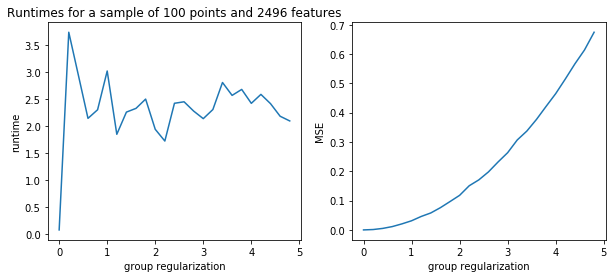

In [192]:
group_s = 32
n_groups = 78
group_sizes = [group_s for i in range(n_groups)]
active_groups = [np.random.randint(2) for _ in group_sizes]
groups = np.concatenate(
    [size * [i] for i, size in enumerate(group_sizes)]).reshape(-1, 1)
n_coeffs = sum(group_sizes)
X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, beta_std, gamma)
print(np.shape(beta))

times = []
MSE_list = []
for group_reg in np.arange(0, 5, 0.2):
    gl = GroupLasso(
        groups=groups,
        group_reg=group_reg,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
    )
    start = time.time()
    gl.fit(X, y)
    stop = time.time()
    times.append(stop-start)
    
    yhat = gl.predict(X)
    sparsity_mask = gl.sparsity_mask_
    beta_hat = gl.coef_

    MSE = mean_squared_error(y, yhat)
    MSE_list.append(MSE)

    
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(np.arange(0, 5, 0.2), times)
plt.xlabel('group regularization')
plt.ylabel('runtime')
plt.title('Runtimes for a sample of 100 points and 2496 features')

plt.subplot(122)
plt.plot(np.arange(0, 5, 0.2), MSE_list)
plt.xlabel('group regularization')
plt.ylabel('MSE')

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [198]:
group_s = 11
n_groups = 12
group_sizes = [group_s for i in range(n_groups)]
active_groups = [np.random.randint(2) for _ in group_sizes]
groups = np.concatenate(
    [size * [i] for i, size in enumerate(group_sizes)]).reshape(-1, 1)
n_coeffs = sum(group_sizes)

n_samples = 1000
beta_std = 1
gamma = 15

b_matrix = make_block_matrix(n_groups, group_s, 0.8)
X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, beta_std, gamma)
np.shape(beta)

(132, 1)

In [194]:
group_reg = 1
gl = GroupLasso(
    groups=groups,
    group_reg=group_reg,
    l1_reg=0,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=10000
)
gl.fit(X, y)

sparsity_mask = gl.sparsity_mask_
beta_hat = gl.coef_

print(f"Number of chosen variables: {sparsity_mask.sum()}")

Number of chosen variables: 77


Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44
Number of chosen variables: 44


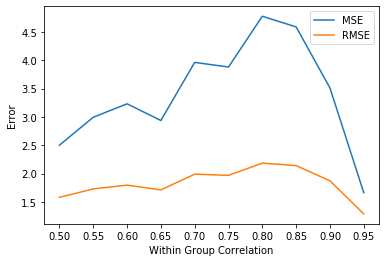

In [350]:
reps = 1

b_matrix_list = [make_block_matrix(n_groups, group_s, corr) for corr in np.arange(0.5, 1, 0.05)]
MSE_list = [[] for _ in range(len(b_matrix_list))]
RMSE_list = [[] for _ in range(len(b_matrix_list))]

for i in range(len(b_matrix_list)):
    for rep in range(reps):
        X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, 
                                     beta_std, gamma, b_matrix_list[i])
        gl_within_correlated = GroupLasso(
        groups=groups,
        group_reg=1,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
        )
        gl_within_correlated.fit(X, y)
        yhat = gl_within_correlated.predict(X)
        sparsity_mask = gl_within_correlated.sparsity_mask_
        beta_hat = gl_within_correlated.coef_

        MSE = mean_squared_error(y, yhat)
        RMSE = np.sqrt(MSE)
        MSE_list[i].append(MSE)
        RMSE_list[i].append(RMSE)
        print(f"Number of chosen variables: {sparsity_mask.sum()}")

MSE_list_mean = np.mean(MSE_list, axis=1)
RMSE_list_mean = np.mean(RMSE_list, axis=1)
assert len(MSE_list_mean) == len(b_matrix_list)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0.5, 1, 0.05) , MSE_list_mean, label='MSE') 
ax.plot(np.arange(0.5, 1, 0.05), RMSE_list_mean, label='RMSE')
ax.legend()
ax.set_xlabel('Within Group Correlation')
ax.set_ylabel('Error')
ax.set_xticks(np.arange(0.5, 1, 0.05))

plt.savefig('plot wgcorr.png', dpi=300, bbox_inches='tight')
plt.show()

In [349]:
reps = 50
b_matrix_list = [make_block_matrix(n_groups, group_s, 0.9, corr) for corr in np.arange(0.5, 0.95, 0.05)]
MSE_list = [[] for _ in range(len(b_matrix_list))]
RMSE_list = [[] for _ in range(len(b_matrix_list))]


for i in range(len(b_matrix_list)):
    for rep in range(reps):
        X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, 
                                     beta_std, gamma, b_matrix_list[i])
        gl_within_correlated = GroupLasso(
        groups=groups,
        group_reg=5,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
        )
        gl_within_correlated.fit(X, y)
        yhat = gl_within_correlated.predict(X)
        sparsity_mask = gl_within_correlated.sparsity_mask_
        beta_hat = gl_within_correlated.coef_

        MSE = mean_squared_error(y, yhat)
        RMSE = np.sqrt(MSE)
        MSE_list[i].append(MSE)
        RMSE_list[i].append(RMSE)

MSE_list_mean = np.mean(MSE_list, axis=1)
RMSE_list_mean = np.mean(RMSE_list, axis=1)
assert len(MSE_list_mean) == len(b_matrix_list)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0.5, 0.95, 0.05) , MSE_list_mean, label='MSE') 
ax.plot(np.arange(0.5, 0.95, 0.05), RMSE_list_mean, label='RMSE')
ax.legend()
ax.set_xlabel('Between Group Correlation (0.9 within group correlation)')
ax.set_ylabel('Error')
ax.set_xticks(np.arange(0.5, 0.95, 0.05))
plt.savefig('plot wgcorr09 bg.png', dpi=300, bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

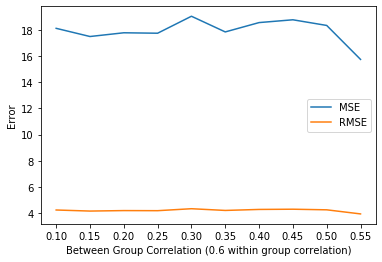

In [323]:
reps = 50
b_matrix_list = [make_block_matrix(n_groups, group_s, 0.6, corr) for corr in np.arange(0.1, 0.6, 0.05)]
MSE_list = [[] for _ in range(len(b_matrix_list))]
RMSE_list = [[] for _ in range(len(b_matrix_list))]


for i in range(len(b_matrix_list)):
    for rep in range(reps):
        X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, 
                                     beta_std, gamma, b_matrix_list[i])
        gl_within_correlated = GroupLasso(
        groups=groups,
        group_reg=5,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
        )
        gl_within_correlated.fit(X, y)
        yhat = gl_within_correlated.predict(X)
        sparsity_mask = gl_within_correlated.sparsity_mask_
        beta_hat = gl_within_correlated.coef_

        MSE = mean_squared_error(y, yhat)
        RMSE = np.sqrt(MSE)
        MSE_list[i].append(MSE)
        RMSE_list[i].append(RMSE)

MSE_list_mean = np.mean(MSE_list, axis=1)
RMSE_list_mean = np.mean(RMSE_list, axis=1)
assert len(MSE_list_mean) == len(b_matrix_list)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0.1, 0.6, 0.05) , MSE_list_mean, label='MSE') 
ax.plot(np.arange(0.1, 0.6, 0.05), RMSE_list_mean, label='RMSE')
ax.legend()
ax.set_xlabel('Between Group Correlation (0.6 within group correlation)')
ax.set_ylabel('Error')
ax.set_xticks(np.arange(0.1, 0.6, 0.05))
plt.savefig('plot wgcorr06 bg.png', dpi=300, bbox_inches='tight')
plt.show()

In [343]:
b_matrix = make_block_matrix(n_groups, group_s, 0.9)
X, beta, y = simulate_regression(n_samples, n_coeffs, group_sizes, active_groups, 
                                     beta_std, gamma, b_matrix)

In [339]:
# Even groups
ng_even = make_group_orderings(groups, [2*i for i in range(int(np.floor(n_groups)/2))])
# Odd groups
ng_odd = make_group_orderings(groups, [2*i + 1 for i in range(int(np.ceil(n_groups)/2))])
# Some random group orders
rand_orders = np.unique([np.random.choice(np.arange(n_groups), 
                                          n_groups, replace=False)for _ in range(100)], axis=0)
ng_rand = [make_group_orderings(groups, grs) for grs in rand_orders]
#different_repeats = [make_group_orderings(groups, np.unique(groups), 
#                    group_reps = tuple(np.random.randint(0,8,n_groups))) for _ in range(100)]





# diff_rep_pattern1 = [make_group_orderings(groups, [0,2,1,3,4,5,6,7,8,9,10,11], 
#                     group_reps = np.random.randint(1,6,n_groups)) for _ in range(100)]

# diff_rep_pattern2 = [make_group_orderings(groups, [0,1,5,3,4,2,7,6,8,9,10,11], 
#                     group_reps = np.random.randint(1,6,n_groups)) for _ in range(100)]

# diff_rep_pattern3 = [make_group_orderings(groups, [8,1,10,11,4,5,6,7,0,9,2,3], 
#                     group_reps = np.random.randint(1,6,n_groups)) for _ in range(100)]

# random_pattern_hs = [make_group_orderings(groups, np.unique(groups), 
#                                        total_shuffles=np.random.randint(len(groups)-40,
#                                        len(groups))) for _ in range(200)]

# random_pattern_ls = [make_group_orderings(groups, np.unique(groups), 
#                                        total_shuffles=np.random.randint(20,
#                                        np.rint(len(groups)/2))) for _ in range(200)]

#Remove elements from groups
removed_groups = [make_group_orderings(groups, np.arange(i, n_groups)) for i in range(1, n_groups)]

In [313]:
random_pattern[4]

array([ 0, 10,  4,  0,  0,  0,  0,  0,  2, 11,  7,  1, 11,  1, 10,  2,  0,
        1,  1,  5,  1,  1,  1,  9,  8,  1,  2,  9,  8,  7, 10,  2,  2,  3,
        7, 11, 11, 11,  3,  3,  8,  6,  6,  2,  4,  8,  3,  4,  2,  9,  4,
        4,  4,  4,  4,  5,  2,  6,  5,  4,  5,  2,  5,  9,  8,  7,  5,  5,
        4,  0,  2,  6,  0,  6,  6,  6,  8,  7,  7,  7,  7,  5, 10,  9,  7,
        3,  8,  7,  4,  8,  8,  2,  8, 10,  9,  6,  3,  5, 11,  6,  0,  9,
        2,  5,  3,  2,  9,  5,  9,  4, 10,  9,  0, 10, 10, 10, 10, 10,  0,
        3, 10, 11,  6,  9, 11, 11, 11, 11,  0,  1, 11,  3])

In [344]:
MSE_list_gr1 = []
for rep in range(100):
    gl = GroupLasso(
        groups=groups,
        group_reg=1,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
    )
    gl.fit(X, y)

    yhat = gl.predict(X)
    sparsity_mask = gl.sparsity_mask_
    beta_hat = gl.coef_

    MSE_list_gr1.append(mean_squared_error(y, yhat))


KeyboardInterrupt: 

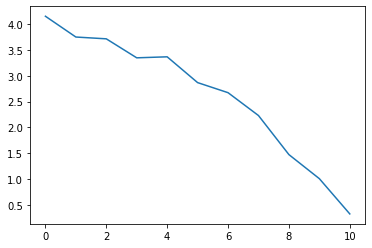

In [345]:
MSE_list_gr1_diffo = []
for gr in removed_groups:
    gl = GroupLasso(
        groups=gr,
        group_reg=1,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=10000
    )
    gl.fit(X, y)

    yhat = gl.predict(X)
    sparsity_mask = gl.sparsity_mask_
    beta_hat = gl.coef_

    MSE_list_gr1_diffo.append(mean_squared_error(y, yhat)) 

plt.plot(np.arange(len(MSE_list_gr1_diffo)), MSE_list_gr1_diffo)
# MSE_list_gr1_diffo1 = []
# for gr in random_pattern_ls:
#     gl1 = GroupLasso(
#         groups=gr,
#         group_reg=1,
#         l1_reg=0,
#         frobenius_lipschitz=True,
#         scale_reg="inverse_group_size",
#         subsampling_scheme=1,
#         supress_warning=True,
#         n_iter=10000
#     )
#     gl1.fit(X, y)

#     yhat = gl1.predict(X)
#     sparsity_mask = gl1.sparsity_mask_
#     beta_hat = gl1.coef_

#     MSE_list_gr1_diffo1.append(mean_squared_error(y, yhat)) 



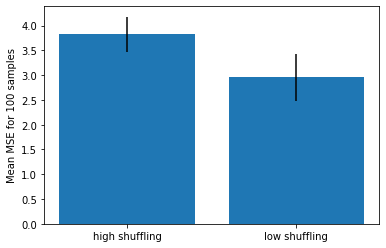

In [316]:
mean1 = np.mean(MSE_list_gr1_diffo)
mean2 = np.mean(MSE_list_gr1_diffo1)


std1 = np.std(MSE_list_gr1_diffo)
std2 = np.std(MSE_list_gr1_diffo1)


xlab = ['high shuffling', 'low shuffling']
plt.bar(xlab, [mean1, mean2], yerr=[std1, std2])
plt.ylabel('Mean MSE for 100 samples')
plt.savefig('plot barplot_sh.png', dpi=300, bbox_inches='tight')


In [338]:
MSE_list_gr1_diffo

[2.6910428727182603,
 2.6930989104195935,
 2.6938866550936993,
 2.6910248165876616,
 2.6914827411380093,
 2.6915296741335157,
 2.6919130650427614,
 2.692890858397393,
 2.6896727703854575,
 2.6936119553783655,
 2.6930334452976523,
 2.690999877194316,
 2.6930996326693104,
 2.6912919270709232,
 2.690842024073443,
 2.693035353283338,
 2.6932993027667473,
 2.6927108675487905,
 2.691040773340149,
 2.6938267624918817,
 2.6909976449020103,
 2.6935314635013046,
 2.6910425856766613,
 2.6934627116647114,
 2.6937655866538934,
 2.6936862818713907,
 2.691964068867622,
 2.693352735703445,
 2.6911766085347315,
 2.691123680231251,
 2.6912079695548026,
 2.6925887661452244,
 2.6912834824719374,
 2.693793199713485,
 2.691138871480497,
 2.6911898659618627,
 2.6929890085455424,
 2.6909990671659276,
 2.691190614855871,
 2.6932582829864082,
 2.6932325189588235,
 2.693090326714215,
 2.6915800458820724,
 2.690738296500566,
 2.6913866597989773,
 2.693126682604354,
 2.691657420068684,
 2.6930607203534267,
 2.6909

X shape: (1000, 600)
Estimated intercept: [0.00528862]


c:\users\avajang-pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000002272103BC48>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
c:\users\avajang-pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000022720F6DD08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


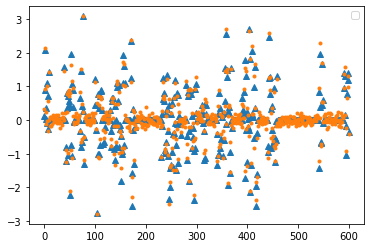

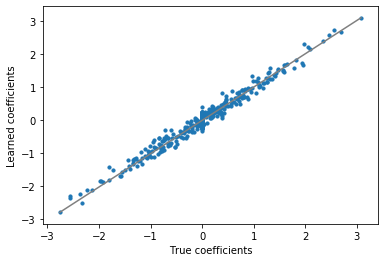

In [463]:
columns = ['MSE', 'RMSE', 'Loss']
rows = ['Group %d' % i for i in range(10)]


plt.figure()
true_weights = plt.plot(beta, "^", label="True weights")
estimated_weights = plt.plot(beta_hat, ".", label="Estimated weights")
plt.legend([true_weights, estimated_weights], ["True weights", "Estimated weights"])

plt.figure()
plt.plot([beta.min(), beta.max()], [beta_hat.min(), beta_hat.max()], "gray")
plt.scatter(beta, beta_hat, s=10)
plt.ylabel("Learned coefficients")
plt.xlabel("True coefficients")


print("X shape: {X.shape}".format(X=X))
print("Estimated intercept: {intercept}".format(intercept=gl.intercept_))
plt.show()

In [482]:
a = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3])
np.unique(a)

array([1, 2, 3])